In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Reshape, Input, Flatten, BatchNormalization
from sklearn.model_selection import train_test_split

In [2]:
import time, datetime
from fyers_apiv3 import fyersModel
import authenticator
client_id = "ZHQ4IJL7TI-100"
access_token = authenticator.authenticate()

fyers = fyersModel.FyersModel(client_id=client_id, is_async=False, token=access_token, log_path="")
market_status = fyers.market_status()

"Market: " + market_status["marketStatus"][1]['status']

'Market: CLOSED'

In [3]:
import matplotlib.pyplot as plt
import numpy as np

In [4]:
from indicators.syncind import SyncInd
from indicators.classic import SMA, Alligator, SmoothMA, RSI, MACD, ATR, WMA, EMA, RMA, VolumeROC, KAMA
from indicators.candle import OHLC
from indicators import epoch_to_time

In [5]:
date_yesterday = (datetime.datetime.now() - datetime.timedelta(days=1)).strftime("%Y-%m-%d")
date_100_p = (datetime.datetime.now() - datetime.timedelta(days=100)).strftime("%Y-%m-%d")
date_yesterday, date_100_p

('2025-03-06', '2024-11-27')

In [6]:
symbol = "NSE:NIFTY50-INDEX"
resolution_1 = "1"

response_1 = fyers.history(data={
                                "symbol": symbol,
                                "resolution": resolution_1,
                                "date_format": "1",
                                "range_from": date_100_p,
                                "range_to": date_yesterday,
                                "cont_flag": "1"
                        })



In [7]:
def remove_duplicates(resp_candels):
    date_temp = []
    final_candles_list = []
    for i in resp_candels:
        if i[0] not in date_temp:
            final_candles_list.append(i)
            date_temp.append(i[0])
    del date_temp
    return final_candles_list


final_candles_list_1 = remove_duplicates(response_1['candles'])
len(final_candles_list_1)

26625

In [8]:
candles_1 = np.array(final_candles_list_1)
candles_1.shape

(26625, 6)

In [9]:
sync_1 = SyncInd(
    SMA(5),
    Alligator(show_jaw=False, show_teeth=False),
    KAMA(highlight=True),
)

for c in candles_1:
    sync_1.append(c)
sync_1.data().shape


(26625, 10)

In [10]:
X, y = [], []
start_ind = 100
back_look = 5
data = sync_1.data()

for ind, i in enumerate(data[start_ind : -back_look]):
    temp = []
    first_candle = data[start_ind+ind-1]
    for j in data[start_ind+ind : start_ind+ind+back_look]:
        # temp = []
        temp.append([round(a, 2) for a in (j[1:]-first_candle[1:]).tolist()[5:]])    
    y.append([round(a, 2) for a in (data[start_ind+ind+back_look][1:] - first_candle[1:]).tolist()[5:]])
    X.append(temp)

X = np.array(X, dtype=np.float16)
y = np.array(y, dtype=np.float16)

"X.shape", X.shape, "y.shape", y.shape

('X.shape', (26520, 5, 4), 'y.shape', (26520, 4))

In [11]:
split_len = 20000
X_train, X_test = X[:split_len], X[split_len:]
y_train, y_test = y[:split_len], y[split_len:]
"X_train.shape", X_train.shape, "X_test.shape", X_test.shape, "y_train.shape", y_train.shape, "y_test.shape", y_test.shape

('X_train.shape',
 (20000, 5, 4),
 'X_test.shape',
 (6520, 5, 4),
 'y_train.shape',
 (20000, 4),
 'y_test.shape',
 (6520, 4))

In [12]:
model = Sequential()
model.add(Input(shape=(5, 4)))
model.add(LSTM(200, activation='tanh', return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(150, activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(4))
# model.add(Reshape((1, 4)))
model.compile(optimizer='adam', loss='mse')

In [13]:
history = model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split=0.2)

Epoch 1/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 109.4225 - val_loss: 37.2101
Epoch 2/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 37.8401 - val_loss: 23.0750
Epoch 3/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 24.4012 - val_loss: 17.4460
Epoch 4/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 23.8602 - val_loss: 13.0006
Epoch 5/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 12.1317 - val_loss: 10.6013
Epoch 6/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 16.2392 - val_loss: 10.0327
Epoch 7/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 12.7923 - val_loss: 8.0444
Epoch 8/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 14.4366 - val_loss: 8.0726
Epoch 9/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 10.3729 - val_loss: 6.4106
Epoch 10/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 10.7384 - val_loss: 7.4683
Epoch 11/500
500/500 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - loss: 9.5383 - val_loss: 6.6855
Epoch 12/500
500/500 ━━━

In [14]:
y_pred = model.predict(X_test)
y_pred

204/204 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


array([[ -0.05815947,  -1.5926759 ,  -0.9387803 ,   0.57861376],
       [  1.2998544 ,  -1.8115472 ,  -0.8787559 ,   0.5711422 ],
       [  2.796772  ,   0.1402697 ,  -0.08826286,   1.5001885 ],
       ...,
       [ -7.9358034 ,  -5.567712  ,  -1.1582066 ,   0.18261671],
       [-10.454218  ,  -7.192561  ,  -3.5077515 ,  -1.3231859 ],
       [-13.885034  ,  -9.666127  ,  -5.324041  ,  -1.6909206 ]],
      dtype=float32)

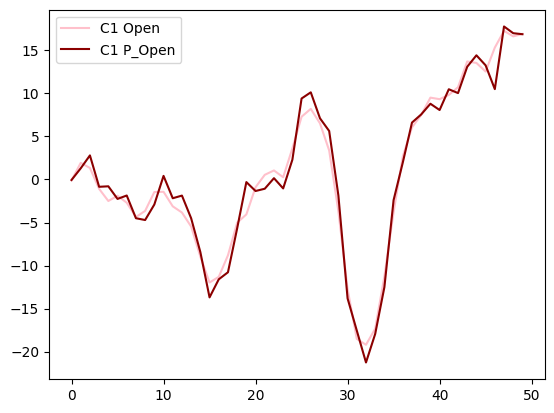

In [15]:
plt.plot(y_test[:50, 0], label='C1 Open', color="pink")
plt.plot(y_pred[:50, 0], label='C1 P_Open', color="darkred")
plt.legend()
plt.show()

In [16]:
model.save("Mar_07_01.keras")

In [17]:
y_pred[:50, 0].shape

(50,)

In [18]:
print("Actual\t\tPredicted\tError")
print("-"*40)
error_list = []
for actual, predicted in zip(y_pred, y_test):
    error = round(float((actual-predicted)[0]), 2)
    print(f"{round(float(actual[0]), 2)}\t\t{round(float(predicted[0]), 2)}\t\t{error}")
    error_list.append(error)

Actual		Predicted	Error
----------------------------------------
-0.06		-0.11		0.05
1.3		1.93		-0.63
2.8		1.34		1.46
-0.85		-1.09		0.24
-0.79		-2.5		1.71
-2.26		-1.89		-0.37
-1.86		-2.7		0.84
-4.5		-4.36		-0.14
-4.71		-3.65		-1.06
-2.91		-1.46		-1.45
0.42		-1.43		1.85
-2.18		-3.12		0.94
-1.87		-3.84		1.97
-4.51		-5.47		0.96
-8.43		-8.97		0.54
-13.7		-11.97		-1.73
-11.6		-11.31		-0.29
-10.78		-8.81		-1.97
-5.68		-5.02		-0.66
-0.3		-4.06		3.76
-1.34		-0.9		-0.44
-1.08		0.54		-1.62
0.15		1.05		-0.9
-1.04		0.26		-1.3
2.3		3.61		-1.31
9.41		7.29		2.12
10.12		8.2		1.92
7.11		6.52		0.59
5.63		3.37		2.26
-1.86		-3.69		1.83
-13.82		-12.73		-1.09
-17.55		-18.52		0.96
-21.26		-19.2		-2.06
-17.94		-17.33		-0.61
-12.51		-11.26		-1.25
-2.39		-3.79		1.4
1.97		2.67		-0.7
6.61		6.05		0.56
7.56		7.5		0.06
8.8		9.51		-0.71
8.07		9.33		-1.26
10.48		9.82		0.66
10.04		10.72		-0.68
13.09		13.71		-0.62
14.42		13.54		0.89
13.26		12.54		0.72
10.5		15.32		-4.82
17.77		17.27		0.51
16.99		16.62		0.37
16.88		16.91	

In [19]:
print("Max\tMin\tMean\tP_err\tN_err\tTotal")
print("-"*45)
error_offset_pos = 5
error_offset_neg = 5
print(f"{max(error_list)}\t{min(error_list)}\t{round(sum(error_list)/len(error_list), 2)}\t{len([a for a in error_list if a > error_offset_pos])}\t{len([a for a in error_list if a < -error_offset_neg])}\t{len(error_list)}")

Max	Min	Mean	P_err	N_err	Total
---------------------------------------------
33.9	-27.6	0.08	152	122	6520
